In [ ]:
# do a new push request

# This section of the code is for all of my imports
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
from datetime import datetime
import glob

# This allows me to access my flash drive that im working off of
os.chdir('/Volumes/Flash Drive')

In [2]:
# This section loads all CSV files from the directory

Path = '/Volumes/Flash Drive/Saturns rings Research/Data From Center of Ringlets CSV files/Ringlet Edges'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(Path, '*.csv'))

print(f"Found {len(csv_files)} CSV files:")
for csv_file in csv_files:
    print(f"  - {os.path.basename(csv_file)}")

Found 12 CSV files:
  - BetCen_075I_1km_ringlet_threshold_data.csv
  - BetCen_077E_1km_ringlet_threshold_data.csv
  - BetCen_077I_1km_ringlet_threshold_data.csv
  - BetCen_078E_1km_ringlet_threshold_data.csv
  - BetCen_081I_1km_ringlet_threshold_data.csv
  - BetCen_085I_1km_ringlet_threshold_data.csv
  - BetCen_089I_1km_ringlet_threshold_data.csv
  - BetCen_092E_1km_ringlet_threshold_data.csv
  - BetCen_096I_1km_ringlet_threshold_data.csv
  - BetCen_102I_1km_ringlet_threshold_data.csv
  - BetCen_104E_1km_ringlet_threshold_data.csv
  - BetCen_104I_1km_ringlet_threshold_data.csv


In [3]:
# This Section is the formulas to convert from UTC to ET time, im working off of ET time

# This formula gets the UTC and ET offset due to leap seconds, number is in seconds
def utc_to_et_offset(year):
    """
    Get the offset between UTC and ET (TDB) in seconds for 2008.
    
    For 2008:
    - Leap seconds accumulated by 2008: 33 seconds
    - TT-TAI offset: 32.184 seconds
    - ET ≈ TDB ≈ TT for most purposes
    - So ET - UTC ≈ 33 + 32.184 = 65.184 seconds
    """
    
    ls = 33  # Leap Seconds since 2008

    # TT - TAI offset is always 32.184 seconds
    tt_tai_offset = 32.184
    
    # ET ≈ TDB ≈ TT = UTC + leap_seconds + 32.184
    et_utc_offset = ls + tt_tai_offset
    
    return et_utc_offset # Seconds

# This section of the code converts the UTC Julian Date to ET Julian Date adding in the leap seconds offset
def convert_paper_time_to_et(jd_utc):
    """
    Convert the paper's UTC-based Julian Date to ET-based Julian Date.
    
    Parameters:
    -----------
    jd_utc : float
        Julian Date in UTC (as used in the paper)
    
    Returns:
    --------
    jd_et : float
        Julian Date in Ephemeris Time
    """
    
    # Get offset for 2008
    et_utc_offset_2008 = utc_to_et_offset(2008)
    
    # Convert to ET
    initial_time = jd_utc + (et_utc_offset_2008 / 86400.0)
    
    return initial_time # Seconds


In [4]:
# This section defines the True Anamoly formula and the radius formula

def calculate_radius_true_anomaly(a, e, true_anomaly):
    """
    Calculate the radius at a given true anomaly for a Keplerian ellipse.
    
    This implements equation (2) from the paper:
    r(λ,t) = a(1 - e²) / (1 + e·cos(f))
    f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
    
    Parameters:
    -----------
    a : float
        Semi-major axis (km)
    e : float
        Eccentricity (dimensionless, between 0 and 1)
    true_anomaly : float or array
        True anomaly f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
        where λ is the inertial longitude and ϖ is the longitude of periapse
    
    Returns:
    --------
    r : float or array
        Radius at the given true anomaly (km)
    """

        # Convert to radians
    #true_anomaly = true_anomaly * np.pi / 180
    
    # Calculate the numerator: a(1 - e²)
    numerator = a * (1 - e**2)
    
    # Calculate the denominator: 1 + e·cos(f)
    denominator = 1 + e * np.cos(true_anomaly)
    
    # Calculate radius
    r = numerator / denominator
    
    return r

def calculate_true_anomaly(longitude #Inertial longitude (LON value)
                           ,varpi_0 # Longitude periapse (Fixed)
                           ,varpi_dot #Rrecession rate (Fixed)
                           ,time # Time from data
                           ,initial_time): # Time from paper (fixed)
    """
    Calculate the true anomaly from orbital parameters.
    
    From the paper: f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
    
    Parameters:
    -----------
    longitude : float or array
        Inertial longitude λ (degrees)
    varpi_0 (Longitude periapse) : float
        Longitude of periapse at epoch ϖ₀ (degrees)
    varpi_dot (precession rate) : float, optional
        Apsidal precession rate ϖ̇ (degrees/day)
    time : float, optional
        Current time (days)
    initial_time : float, optional
        Epoch time t₀ (days)
    
    Returns:
    --------
    true_anomaly : float or array
        True anomaly f (degrees)
    """
    
    # True anomaly is the angle from periapse
    true_anomaly = longitude - varpi_0 - varpi_dot * (time - initial_time)

    # Wrap to 0-360 degrees
    true_anomaly = true_anomaly % 360
    
    return true_anomaly

def plot_r_vs_true_anomaly(true_anomaly, radii, title=f"\Radius vs True Anomaly Analysis of Titan Ringlet \n File: {csv_files}"):
    """
    Plot radius vs true anomaly.
    
    Parameters:
    -----------
    true_anomaly : array
        True anomaly values in degrees
    radii : array
        Radius values in km
    title : str
        Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(true_anomaly, radii, 'b-', linewidth=2)
    plt.xlabel('True Anomaly, f (degrees)')
    plt.ylabel('Radius (km)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
# This section defines static parameters and initializes data storage

# J2000 epoch = JD 2451545.0
j2000_jd = 2451545.0

# Paper's epoch
paper_epoch_utc = 2454467.0  # This is in UTC

# Paper's epoch conversion to ET (seconds)
paper_epoch_jd_et = convert_paper_time_to_et(paper_epoch_utc)

# Static orbital parameters/Paper values (these don't change between occultations)
a_paper = 77867.13  # km
ae_paper = 17.39    # km 
e_paper = ae_paper / a_paper
ae = 17.39    # km
varpi_0 = 270.54  # degrees
varpi_dot = 22.57503  # ϖ̇ in degrees/day

# Initialize lists to store data points from all occultations
# Separate lists for inner and outer edges
all_true_anomaly_inner = []
all_radii_inner = []
all_longitudes_inner = []
all_times_inner = []
all_TAUPLUS_inner = []
all_TAUMINUS_inner = []
all_true_anomaly_outer = []
all_radii_outer = []
all_longitudes_outer = []
all_times_outer = []
all_TAUPLUS_outer = []
all_TAUMINUS_outer = []
all_csv_names = []

print("Fixed orbital parameters:")
print(f"  ae = {ae} km")
print(f"  varpi_0 = {varpi_0}°")
print(f"  varpi_dot = {varpi_dot}°/day")
print(f"  paper_epoch_jd_et = {paper_epoch_jd_et} JD")

Fixed orbital parameters:
  ae = 17.39 km
  varpi_0 = 270.54°
  varpi_dot = 22.57503°/day
  paper_epoch_jd_et = 2454467.0007544444 JD


In [6]:
# This section loops through all CSV files and processes each one for Titan Ringlet
print(f"\nProcessing {len(csv_files)} CSV files...\n")

for csv_file in csv_files:
    csv_name = os.path.basename(csv_file)
    print(f"Processing: {csv_name}")
    
    try:
        # Load data from CSV
        data = pd.read_csv(csv_file)
        
        # Get Titan inner and outer edge data
        titan_inner = data[data['Ringlet_Position'] == 'Titan_Inner']
        titan_outer = data[data['Ringlet_Position'] == 'Titan_Outer']
        
        if len(titan_inner) == 0 and len(titan_outer) == 0:
            print(f"  ⚠ No Titan ringlet data found in {csv_name}")
            continue
        
        # Process Inner Edge
        if len(titan_inner) > 0:
            # Extract radius value from CSV for inner edge
            a_inner = titan_inner['Radius'].values[0]
            
            # Calculate eccentricity (using ae from paper then using our radial value)
            e_inner = ae / a_inner
            
            # Get longitude from data
            longitude_inner = titan_inner['LON'].values[0]  # LON in degrees

            # Get TAUPLUS from data
            TAUPLUS_inner = titan_inner['TAUPLUS'].values[0]  # TAUPLUS

            # Get TAUMINUS from data
            TAUMINUS_inner = titan_inner['TAUMINUS'].values[0]  # TAUMINUS
            
            # Convert ET time from seconds to days
            titan_et_days_inner = titan_inner['ET'].values[0] / 86400.0
            
            # Convert to Julian Days
            titan_jd_et_inner = j2000_jd + titan_et_days_inner
            
            # Calculate true anomaly (comes out in degrees after wrapping)
            true_anomaly_inner = calculate_true_anomaly(longitude_inner, varpi_0, varpi_dot, 
                                                 titan_jd_et_inner, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_inner = true_anomaly_inner * np.pi / 180
            
            # Calculate radii
            radii_inner = calculate_radius_true_anomaly(a_inner, e_inner, true_anomaly_rad_inner)
            
            # Store inner edge data points
            all_true_anomaly_inner.append(true_anomaly_inner)
            all_radii_inner.append(radii_inner)
            all_longitudes_inner.append(longitude_inner)
            all_times_inner.append(titan_jd_et_inner)
            all_TAUPLUS_inner.append(TAUPLUS_inner)
            all_TAUMINUS_inner.append(TAUMINUS_inner)
            
            print(f"  ✓ Inner edge: a = {a_inner:.2f} km")
        
        # Process Outer Edge
        if len(titan_outer) > 0:
            # Extract radius value from CSV for outer edge
            a_outer = titan_outer['Radius'].values[0]
            
            # Calculate eccentricity (using ae from paper then using our radial value)
            e_outer = ae / a_outer
            
            # Get longitude from data
            longitude_outer = titan_outer['LON'].values[0]  # LON in degrees

            # Get TAUPLUS from data
            TAUPLUS_outer = titan_outer['TAUPLUS'].values[0]  # TAUPLUS

            # Get TAUMINUS from data
            TAUMINUS_outer = titan_outer['TAUMINUS'].values[0]  # TAUMINUS
            
            # Convert ET time from seconds to days
            titan_et_days_outer = titan_outer['ET'].values[0] / 86400.0
            
            # Convert to Julian Days
            titan_jd_et_outer = j2000_jd + titan_et_days_outer
            
            # Calculate true anomaly (comes out in degrees after wrapping)
            true_anomaly_outer = calculate_true_anomaly(longitude_outer, varpi_0, varpi_dot, 
                                                 titan_jd_et_outer, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_outer = true_anomaly_outer * np.pi / 180
            
            # Calculate radii
            radii_outer = calculate_radius_true_anomaly(a_outer, e_outer, true_anomaly_rad_outer)
            
            # Store outer edge data points
            all_true_anomaly_outer.append(true_anomaly_outer)
            all_radii_outer.append(radii_outer)
            all_longitudes_outer.append(longitude_outer)
            all_times_outer.append(titan_jd_et_outer)
            all_TAUPLUS_outer.append(TAUPLUS_outer)
            all_TAUMINUS_outer.append(TAUMINUS_outer)
            
            print(f"  ✓ Outer edge: a = {a_outer:.2f} km")
        
        all_csv_names.append(csv_name)
        
    except Exception as ex:
        print(f"  ✗ Error processing {csv_name}: {ex}")
        import traceback
        traceback.print_exc()
        continue

# Convert lists to numpy arrays
all_true_anomaly_inner = np.array(all_true_anomaly_inner)
all_radii_inner = np.array(all_radii_inner)
all_longitudes_inner = np.array(all_longitudes_inner)
all_times_inner = np.array(all_times_inner)
all_TAUPLUS_inner = np.array(all_TAUPLUS_inner)
all_TAUMINUS_inner = np.array(all_TAUMINUS_inner)

all_true_anomaly_outer = np.array(all_true_anomaly_outer)
all_radii_outer = np.array(all_radii_outer)
all_longitudes_outer = np.array(all_longitudes_outer)
all_times_outer = np.array(all_times_outer)
all_TAUPLUS_outer = np.array(all_TAUPLUS_outer)
all_TAUMINUS_outer = np.array(all_TAUMINUS_outer)

print(f"\n{'='*60}")
print(f"TOTAL DATA POINTS COLLECTED:")
print(f"  Inner edge: {len(all_true_anomaly_inner)} points")
print(f"  Outer edge: {len(all_true_anomaly_outer)} points")
print(f"  Total: {len(all_true_anomaly_inner) + len(all_true_anomaly_outer)} points")
print(f"  Total Tau+- values Inner: {len(all_TAUPLUS_inner) + len(all_TAUMINUS_inner)} points")
print(f"  Total Tau+- values Outer: {len(all_TAUPLUS_outer) + len(all_TAUMINUS_outer)} points")
print(f"{'='*60}")

if len(all_true_anomaly_inner) > 0:
    print(f"Inner - True anomaly: {np.min(all_true_anomaly_inner):.2f}° to {np.max(all_true_anomaly_inner):.2f}°")
    print(f"Inner - Radii: {np.min(all_radii_inner):.2f} to {np.max(all_radii_inner):.2f} km")

if len(all_true_anomaly_outer) > 0:
    print(f"Outer - True anomaly: {np.min(all_true_anomaly_outer):.2f}° to {np.max(all_true_anomaly_outer):.2f}°")
    print(f"Outer - Radii: {np.min(all_radii_outer):.2f} to {np.max(all_radii_outer):.2f} km")


Processing 12 CSV files...

Processing: BetCen_075I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77856.00 km
  ✓ Outer edge: a = 77865.00 km
Processing: BetCen_077E_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77874.00 km
  ✓ Outer edge: a = 77895.00 km
Processing: BetCen_077I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77847.00 km
  ✓ Outer edge: a = 77863.00 km
Processing: BetCen_078E_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77870.00 km
  ✓ Outer edge: a = 77893.00 km
Processing: BetCen_081I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77866.00 km
  ✓ Outer edge: a = 77884.00 km
Processing: BetCen_085I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77878.00 km
  ✓ Outer edge: a = 77909.00 km
Processing: BetCen_089I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77882.00 km
  ✓ Outer edge: a = 77913.00 km
Processing: BetCen_092E_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77861.00 km
  ✓ Outer edge: a = 77888.00 km
Processing: BetCen_

In [7]:
""" # This part creates the model curve using paper parameters (Might not need commenting out for now)

# Create model curve (sampling all true anomalies)
true_anomaly_deg_model = np.linspace(0, 360, 1000)
true_anomaly_rad_model = true_anomaly_deg_model * np.pi / 180

# Paper parameters for model
a_paper = 77867.13  # km
ae_paper = 17.39    # km 
e_paper = ae_paper / a_paper

model_radii = calculate_radius_true_anomaly(a_paper, e_paper, true_anomaly_rad_model)

print(f"Model parameters:")
print(f"  a_paper = {a_paper} km")
print(f"  e_paper = {e_paper:.6f}")
print(f"  Model radius range: {np.min(model_radii):.2f} to {np.max(model_radii):.2f} km")
"""

' # This part creates the model curve using paper parameters (Might not need commenting out for now)\n\n# Create model curve (sampling all true anomalies)\ntrue_anomaly_deg_model = np.linspace(0, 360, 1000)\ntrue_anomaly_rad_model = true_anomaly_deg_model * np.pi / 180\n\n# Paper parameters for model\na_paper = 77867.13  # km\nae_paper = 17.39    # km \ne_paper = ae_paper / a_paper\n\nmodel_radii = calculate_radius_true_anomaly(a_paper, e_paper, true_anomaly_rad_model)\n\nprint(f"Model parameters:")\nprint(f"  a_paper = {a_paper} km")\nprint(f"  e_paper = {e_paper:.6f}")\nprint(f"  Model radius range: {np.min(model_radii):.2f} to {np.max(model_radii):.2f} km")\n'

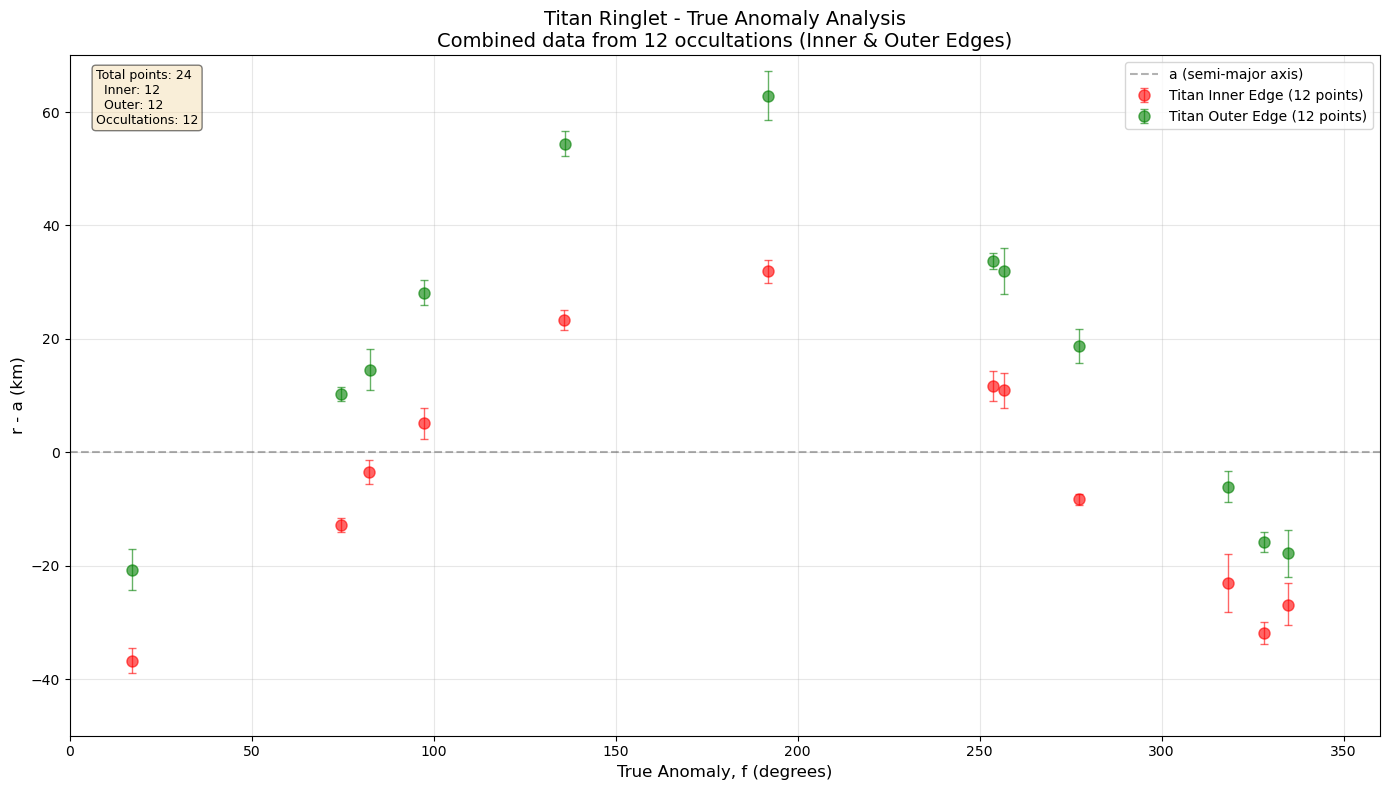


Plot generated with 24 total data points from 12 CSV files
  - Inner edge: 12 points (red circles)
  - Outer edge: 12 points (green squares)


In [12]:
# This section plots the model curve with ALL data points from all occultations for Titan ringlet

plt.figure(figsize=(14, 8))

# Plot inner edge data points with error bars (red circles)
plt.errorbar(all_true_anomaly_inner, all_radii_inner - a_paper, 
             yerr=[all_TAUMINUS_inner, all_TAUPLUS_inner],  # Asymmetric error bars
             fmt='ro', markersize=8, capsize=3, capthick=1, 
             label=f'Titan Inner Edge ({len(all_true_anomaly_inner)} points)', 
             alpha=0.6, elinewidth=1)

# Plot outer edge data points with error bars (green circles)
plt.errorbar(all_true_anomaly_outer, all_radii_outer - a_paper, 
             yerr=[all_TAUMINUS_outer, all_TAUPLUS_outer],  # Asymmetric error bars
             fmt='go', markersize=8, capsize=3, capthick=1,
             label=f'Titan Outer Edge ({len(all_true_anomaly_outer)} points)', 
             alpha=0.6, elinewidth=1)

# Formatting
plt.xlabel('True Anomaly, f (degrees)', fontsize=12)
plt.ylabel('r - a (km)', fontsize=12)
plt.title(f'Titan Ringlet - True Anomaly Analysis\nCombined data from {len(all_csv_names)} occultations (Inner & Outer Edges)', fontsize=14)
plt.xlim(0, 360)
plt.ylim(-50, 70)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with statistics
total_points = len(all_true_anomaly_inner) + len(all_true_anomaly_outer)
stats_text = f'Total points: {total_points}\n'
stats_text += f'  Inner: {len(all_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(all_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(all_csv_names)}'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {total_points} total data points from {len(all_csv_names)} CSV files")
print(f"  - Inner edge: {len(all_true_anomaly_inner)} points (red circles)")
print(f"  - Outer edge: {len(all_true_anomaly_outer)} points (green squares)")

In [ ]:
# This section plots the data with fitted curves and saves the figure

# Define the ringlet name and output path
ringlet_name = "Titan"
output_path = "/Volumes/Flash Drive/Saturns rings Research/Screenshot Outputs/True Anomoly Graph for different Ringlets"
output_filename = f"{ringlet_name}_True_Anomaly_Fit.png"
full_output_path = os.path.join(output_path, output_filename)

# Create the figure
plt.figure(figsize=(14, 8))

# Plot paper model curve (light blue, dashed)
plt.plot(true_anomaly_deg_model, model_radii - a_paper, 'c--', linewidth=1.5, 
         label='Paper Model', alpha=0.5)

# Plot fitted curves
if fitted_radii_inner is not None and a_fit_inner is not None:
    plt.plot(true_anomaly_deg_model, fitted_radii_inner - a_fit_inner, 'r-', linewidth=2.5, 
             label=f'Inner Edge Fit (a={a_fit_inner:.2f} km)', alpha=0.8)

if fitted_radii_outer is not None and a_fit_outer is not None:
    plt.plot(true_anomaly_deg_model, fitted_radii_outer - a_fit_outer, 'g-', linewidth=2.5, 
             label=f'Outer Edge Fit (a={a_fit_outer:.2f} km)', alpha=0.8)

# Plot data points
if len(all_true_anomaly_inner) > 0:
    # Use fitted a value if available, otherwise use paper value
    a_ref_inner = a_fit_inner if a_fit_inner is not None else a_paper
    plt.plot(all_true_anomaly_inner, all_radii_inner - a_ref_inner, 'ro', markersize=6, 
             label=f'Inner Edge Data ({len(all_true_anomaly_inner)} points)', alpha=0.6)

if len(all_true_anomaly_outer) > 0:
    # Use fitted a value if available, otherwise use paper value
    a_ref_outer = a_fit_outer if a_fit_outer is not None else a_paper
    plt.plot(all_true_anomaly_outer, all_radii_outer - a_ref_outer, 'gs', markersize=6, 
             label=f'Outer Edge Data ({len(all_true_anomaly_outer)} points)', alpha=0.6)

# Formatting
plt.xlabel('True Anomaly, f (degrees)', fontsize=12)
plt.ylabel('r - a (km)', fontsize=12)
plt.title(f'{ringlet_name} Ringlet - True Anomaly Analysis with Curve Fits\n' + 
          f'Combined data from {len(all_csv_names)} occultations', fontsize=14, fontweight='bold')
plt.xlim(0, 360)
plt.ylim(-50, 20)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.legend(fontsize=9, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with statistics and fit parameters
total_points = len(all_true_anomaly_inner) + len(all_true_anomaly_outer)
stats_text = f'Total points: {total_points}\n'
stats_text += f'  Inner: {len(all_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(all_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(all_csv_names)}\n'
stats_text += '\nFitted Parameters:\n'

if a_fit_inner is not None:
    stats_text += f'Inner: a={a_fit_inner:.2f} km\n'
    stats_text += f'       e={e_fit_inner:.6f}\n'
if a_fit_outer is not None:
    stats_text += f'Outer: a={a_fit_outer:.2f} km\n'
    stats_text += f'       e={e_fit_outer:.6f}'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=8, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()

# Save the figure
try:
    # Create directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    plt.savefig(full_output_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Figure saved to: {full_output_path}")
except Exception as ex:
    print(f"\n✗ Error saving figure: {ex}")

plt.show()

print(f"\nFinal plot generated with fitted curves")
print(f"  - Inner edge: {len(all_true_anomaly_inner)} points (red circles) with red fitted curve")
print(f"  - Outer edge: {len(all_true_anomaly_outer)} points (green squares) with green fitted curve")

In [ ]:
# ========== MAXWELL RINGLET ANALYSIS ==========

# This section defines static parameters and initializes data storage for Maxwell Ringlet

# Initialize lists to store data points from all occultations for Maxwell
# Separate lists for inner and outer edges
maxwell_true_anomaly_inner = []
maxwell_radii_inner = []
maxwell_true_anomaly_outer = []
maxwell_radii_outer = []
maxwell_csv_names = []

print("\n" + "="*60)
print("MAXWELL RINGLET - Initializing data storage")
print("="*60)

In [ ]:
# This section loops through all CSV files and processes each one for Maxwell Ringlet

print(f"\nProcessing {len(csv_files)} CSV files for Maxwell Ringlet...\n")

for csv_file in csv_files:
    csv_name = os.path.basename(csv_file)
    print(f"Processing: {csv_name}")
    
    try:
        # Load data from CSV
        data = pd.read_csv(csv_file)
        
        # Check if the new column structure exists
        if 'Maxwell_Inner' not in data.columns or 'Maxwell_Outer' not in data.columns:
            print(f"  ⚠ Required columns 'Maxwell_Inner' or 'Maxwell_Outer' not found in {csv_name}")
            continue
        
        # Process Maxwell Inner Edge
        if pd.notna(data['Maxwell_Inner'].iloc[0]):  # Check if data exists
            a_inner = data['Maxwell_Inner'].iloc[0]  # Get inner edge radius
            e_inner = ae / a_inner
            
            # Get other required columns
            longitude = data['LON'].values
            maxwell_data_et_days = data['ET'].values / 86400.0
            maxwell_data_jd_et = j2000_jd + maxwell_data_et_days
            
            # Calculate true anomaly for inner edge
            true_anomaly_inner = calculate_true_anomaly(longitude, varpi_0, varpi_dot, 
                                                        maxwell_data_jd_et, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_inner = true_anomaly_inner * np.pi / 180
            
            # Calculate radii for inner edge
            radii_inner = calculate_radius_true_anomaly(a_inner, e_inner, true_anomaly_rad_inner)
            
            # Store inner edge data points
            maxwell_true_anomaly_inner.extend(true_anomaly_inner)
            maxwell_radii_inner.extend(radii_inner)
            
            print(f"  ✓ Inner edge: a = {a_inner:.2f} km, {len(true_anomaly_inner)} points")
        
        # Process Maxwell Outer Edge
        if pd.notna(data['Maxwell_Outer'].iloc[0]):  # Check if data exists
            a_outer = data['Maxwell_Outer'].iloc[0]  # Get outer edge radius
            e_outer = ae / a_outer
            
            # Get other required columns (reuse if already loaded)
            if 'longitude' not in locals():
                longitude = data['LON'].values
                maxwell_data_et_days = data['ET'].values / 86400.0
                maxwell_data_jd_et = j2000_jd + maxwell_data_et_days
            
            # Calculate true anomaly for outer edge
            true_anomaly_outer = calculate_true_anomaly(longitude, varpi_0, varpi_dot, 
                                                        maxwell_data_jd_et, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_outer = true_anomaly_outer * np.pi / 180
            
            # Calculate radii for outer edge
            radii_outer = calculate_radius_true_anomaly(a_outer, e_outer, true_anomaly_rad_outer)
            
            # Store outer edge data points
            maxwell_true_anomaly_outer.extend(true_anomaly_outer)
            maxwell_radii_outer.extend(radii_outer)
            
            print(f"  ✓ Outer edge: a = {a_outer:.2f} km, {len(true_anomaly_outer)} points")
        
        maxwell_csv_names.append(csv_name)
        
    except Exception as ex:
        print(f"  ✗ Error processing {csv_name}: {ex}")
        import traceback
        traceback.print_exc()
        continue

# Convert lists to numpy arrays for easier manipulation
maxwell_true_anomaly_inner = np.array(maxwell_true_anomaly_inner)
maxwell_radii_inner = np.array(maxwell_radii_inner)
maxwell_true_anomaly_outer = np.array(maxwell_true_anomaly_outer)
maxwell_radii_outer = np.array(maxwell_radii_outer)

print(f"\n{'='*60}")
print(f"MAXWELL RINGLET - TOTAL DATA POINTS COLLECTED:")
print(f"  Inner edge: {len(maxwell_true_anomaly_inner)} points")
print(f"  Outer edge: {len(maxwell_true_anomaly_outer)} points")
print(f"  Total: {len(maxwell_true_anomaly_inner) + len(maxwell_true_anomaly_outer)} points")
print(f"{'='*60}")

if len(maxwell_true_anomaly_inner) > 0:
    print(f"Inner edge - True anomaly range: {np.min(maxwell_true_anomaly_inner):.2f}° to {np.max(maxwell_true_anomaly_inner):.2f}°")
    print(f"Inner edge - Radii range: {np.min(maxwell_radii_inner):.2f} to {np.max(maxwell_radii_inner):.2f} km")

if len(maxwell_true_anomaly_outer) > 0:
    print(f"Outer edge - True anomaly range: {np.min(maxwell_true_anomaly_outer):.2f}° to {np.max(maxwell_true_anomaly_outer):.2f}°")
    print(f"Outer edge - Radii range: {np.min(maxwell_radii_outer):.2f} to {np.max(maxwell_radii_outer):.2f} km")

In [ ]:
# This section plots the model curve with ALL data points from all occultations for Maxwell ringlet

plt.figure(figsize=(14, 8))

# Plot inner edge data points (red circles)
if len(maxwell_true_anomaly_inner) > 0:
    plt.plot(maxwell_true_anomaly_inner, maxwell_radii_inner - a_paper, 'ro', markersize=8, 
             label=f'Maxwell Inner Edge ({len(maxwell_true_anomaly_inner)} points)', alpha=0.6)

# Plot outer edge data points (green squares)
if len(maxwell_true_anomaly_outer) > 0:
    plt.plot(maxwell_true_anomaly_outer, maxwell_radii_outer - a_paper, 'gs', markersize=8, 
             label=f'Maxwell Outer Edge ({len(maxwell_true_anomaly_outer)} points)', alpha=0.6)

# Formatting
plt.xlabel('True Anomaly, f (degrees)', fontsize=12)
plt.ylabel('r - a (km)', fontsize=12)
plt.title(f'Maxwell Ringlet - True Anomaly Analysis\nCombined data from {len(maxwell_csv_names)} occultations (Inner & Outer Edges)', fontsize=14)
plt.xlim(0, 360)
plt.ylim(-50, 20)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with statistics
maxwell_total_points = len(maxwell_true_anomaly_inner) + len(maxwell_true_anomaly_outer)
stats_text = f'Total points: {maxwell_total_points}\n'
stats_text += f'  Inner: {len(maxwell_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(maxwell_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(maxwell_csv_names)}'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {maxwell_total_points} total data points from {len(maxwell_csv_names)} CSV files")
print(f"  - Inner edge: {len(maxwell_true_anomaly_inner)} points (red circles)")
print(f"  - Outer edge: {len(maxwell_true_anomaly_outer)} points (green squares)")

In [ ]:
# ========== BOND RINGLET ANALYSIS ==========

# This section defines static parameters and initializes data storage for Bond Ringlet

# Initialize lists to store data points from all occultations for Bond
# Separate lists for inner and outer edges
bond_true_anomaly_inner = []
bond_radii_inner = []
bond_true_anomaly_outer = []
bond_radii_outer = []
bond_csv_names = []

print("\n" + "="*60)
print("BOND RINGLET - Initializing data storage")
print("="*60)

In [ ]:
# This section loops through all CSV files and processes each one for Bond Ringlet

print(f"\nProcessing {len(csv_files)} CSV files for Bond Ringlet...\n")

for csv_file in csv_files:
    csv_name = os.path.basename(csv_file)
    print(f"Processing: {csv_name}")
    
    try:
        # Load data from CSV
        data = pd.read_csv(csv_file)
        
        # Check if the new column structure exists
        if 'Bond_Inner' not in data.columns or 'Bond_Outer' not in data.columns:
            print(f"  ⚠ Required columns 'Bond_Inner' or 'Bond_Outer' not found in {csv_name}")
            continue
        
        # Process Bond Inner Edge
        if pd.notna(data['Bond_Inner'].iloc[0]):  # Check if data exists
            a_inner = data['Bond_Inner'].iloc[0]  # Get inner edge radius
            e_inner = ae / a_inner
            
            # Get other required columns
            longitude = data['LON'].values
            bond_data_et_days = data['ET'].values / 86400.0
            bond_data_jd_et = j2000_jd + bond_data_et_days
            
            # Calculate true anomaly for inner edge
            true_anomaly_inner = calculate_true_anomaly(longitude, varpi_0, varpi_dot, 
                                                        bond_data_jd_et, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_inner = true_anomaly_inner * np.pi / 180
            
            # Calculate radii for inner edge
            radii_inner = calculate_radius_true_anomaly(a_inner, e_inner, true_anomaly_rad_inner)
            
            # Store inner edge data points
            bond_true_anomaly_inner.extend(true_anomaly_inner)
            bond_radii_inner.extend(radii_inner)
            
            print(f"  ✓ Inner edge: a = {a_inner:.2f} km, {len(true_anomaly_inner)} points")
        
        # Process Bond Outer Edge
        if pd.notna(data['Bond_Outer'].iloc[0]):  # Check if data exists
            a_outer = data['Bond_Outer'].iloc[0]  # Get outer edge radius
            e_outer = ae / a_outer
            
            # Get other required columns (reuse if already loaded)
            if 'longitude' not in locals():
                longitude = data['LON'].values
                bond_data_et_days = data['ET'].values / 86400.0
                bond_data_jd_et = j2000_jd + bond_data_et_days
            
            # Calculate true anomaly for outer edge
            true_anomaly_outer = calculate_true_anomaly(longitude, varpi_0, varpi_dot, 
                                                        bond_data_jd_et, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_outer = true_anomaly_outer * np.pi / 180
            
            # Calculate radii for outer edge
            radii_outer = calculate_radius_true_anomaly(a_outer, e_outer, true_anomaly_rad_outer)
            
            # Store outer edge data points
            bond_true_anomaly_outer.extend(true_anomaly_outer)
            bond_radii_outer.extend(radii_outer)
            
            print(f"  ✓ Outer edge: a = {a_outer:.2f} km, {len(true_anomaly_outer)} points")
        
        bond_csv_names.append(csv_name)
        
    except Exception as ex:
        print(f"  ✗ Error processing {csv_name}: {ex}")
        import traceback
        traceback.print_exc()
        continue

# Convert lists to numpy arrays for easier manipulation
bond_true_anomaly_inner = np.array(bond_true_anomaly_inner)
bond_radii_inner = np.array(bond_radii_inner)
bond_true_anomaly_outer = np.array(bond_true_anomaly_outer)
bond_radii_outer = np.array(bond_radii_outer)

print(f"\n{'='*60}")
print(f"BOND RINGLET - TOTAL DATA POINTS COLLECTED:")
print(f"  Inner edge: {len(bond_true_anomaly_inner)} points")
print(f"  Outer edge: {len(bond_true_anomaly_outer)} points")
print(f"  Total: {len(bond_true_anomaly_inner) + len(bond_true_anomaly_outer)} points")
print(f"{'='*60}")

if len(bond_true_anomaly_inner) > 0:
    print(f"Inner edge - True anomaly range: {np.min(bond_true_anomaly_inner):.2f}° to {np.max(bond_true_anomaly_inner):.2f}°")
    print(f"Inner edge - Radii range: {np.min(bond_radii_inner):.2f} to {np.max(bond_radii_inner):.2f} km")

if len(bond_true_anomaly_outer) > 0:
    print(f"Outer edge - True anomaly range: {np.min(bond_true_anomaly_outer):.2f}° to {np.max(bond_true_anomaly_outer):.2f}°")
    print(f"Outer edge - Radii range: {np.min(bond_radii_outer):.2f} to {np.max(bond_radii_outer):.2f} km")

In [ ]:
# This section plots the model curve with ALL data points from all occultations for Bond ringlet

plt.figure(figsize=(14, 8))

# Plot inner edge data points (red circles)
if len(bond_true_anomaly_inner) > 0:
    plt.plot(bond_true_anomaly_inner, bond_radii_inner - a_paper, 'ro', markersize=8, 
             label=f'Bond Inner Edge ({len(bond_true_anomaly_inner)} points)', alpha=0.6)

# Plot outer edge data points (green squares)
if len(bond_true_anomaly_outer) > 0:
    plt.plot(bond_true_anomaly_outer, bond_radii_outer - a_paper, 'gs', markersize=8, 
             label=f'Bond Outer Edge ({len(bond_true_anomaly_outer)} points)', alpha=0.6)

# Formatting
plt.xlabel('True Anomaly, f (degrees)', fontsize=12)
plt.ylabel('r - a (km)', fontsize=12)
plt.title(f'Bond Ringlet - True Anomaly Analysis\nCombined data from {len(bond_csv_names)} occultations (Inner & Outer Edges)', fontsize=14)
plt.xlim(0, 360)
plt.ylim(-50, 20)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with statistics
bond_total_points = len(bond_true_anomaly_inner) + len(bond_true_anomaly_outer)
stats_text = f'Total points: {bond_total_points}\n'
stats_text += f'  Inner: {len(bond_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(bond_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(bond_csv_names)}'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {bond_total_points} total data points from {len(bond_csv_names)} CSV files")
print(f"  - Inner edge: {len(bond_true_anomaly_inner)} points (red circles)")
print(f"  - Outer edge: {len(bond_true_anomaly_outer)} points (green squares)")

In [ ]:
# ========== HUYGENS RINGLET ANALYSIS ==========

# This section defines static parameters and initializes data storage for Huygens Ringlet

# Initialize lists to store data points from all occultations for Huygens
# Separate lists for inner and outer edges
huygens_true_anomaly_inner = []
huygens_radii_inner = []
huygens_true_anomaly_outer = []
huygens_radii_outer = []
huygens_csv_names = []

print("\n" + "="*60)
print("HUYGENS RINGLET - Initializing data storage")
print("="*60)

In [ ]:
# This section loops through all CSV files and processes each one for Huygens Ringlet

print(f"\nProcessing {len(csv_files)} CSV files for Huygens Ringlet...\n")

for csv_file in csv_files:
    csv_name = os.path.basename(csv_file)
    print(f"Processing: {csv_name}")
    
    try:
        # Load data from CSV
        data = pd.read_csv(csv_file)
        
        # Check if the new column structure exists
        if 'Huygens_Inner' not in data.columns or 'Huygens_Outer' not in data.columns:
            print(f"  ⚠ Required columns 'Huygens_Inner' or 'Huygens_Outer' not found in {csv_name}")
            continue
        
        # Process Huygens Inner Edge
        if pd.notna(data['Huygens_Inner'].iloc[0]):  # Check if data exists
            a_inner = data['Huygens_Inner'].iloc[0]  # Get inner edge radius
            e_inner = ae / a_inner
            
            # Get other required columns
            longitude = data['LON'].values
            huygens_data_et_days = data['ET'].values / 86400.0
            huygens_data_jd_et = j2000_jd + huygens_data_et_days
            
            # Calculate true anomaly for inner edge
            true_anomaly_inner = calculate_true_anomaly(longitude, varpi_0, varpi_dot, 
                                                        huygens_data_jd_et, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_inner = true_anomaly_inner * np.pi / 180
            
            # Calculate radii for inner edge
            radii_inner = calculate_radius_true_anomaly(a_inner, e_inner, true_anomaly_rad_inner)
            
            # Store inner edge data points
            huygens_true_anomaly_inner.extend(true_anomaly_inner)
            huygens_radii_inner.extend(radii_inner)
            
            print(f"  ✓ Inner edge: a = {a_inner:.2f} km, {len(true_anomaly_inner)} points")
        
        # Process Huygens Outer Edge
        if pd.notna(data['Huygens_Outer'].iloc[0]):  # Check if data exists
            a_outer = data['Huygens_Outer'].iloc[0]  # Get outer edge radius
            e_outer = ae / a_outer
            
            # Get other required columns (reuse if already loaded)
            if 'longitude' not in locals():
                longitude = data['LON'].values
                huygens_data_et_days = data['ET'].values / 86400.0
                huygens_data_jd_et = j2000_jd + huygens_data_et_days
            
            # Calculate true anomaly for outer edge
            true_anomaly_outer = calculate_true_anomaly(longitude, varpi_0, varpi_dot, 
                                                        huygens_data_jd_et, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_outer = true_anomaly_outer * np.pi / 180
            
            # Calculate radii for outer edge
            radii_outer = calculate_radius_true_anomaly(a_outer, e_outer, true_anomaly_rad_outer)
            
            # Store outer edge data points
            huygens_true_anomaly_outer.extend(true_anomaly_outer)
            huygens_radii_outer.extend(radii_outer)
            
            print(f"  ✓ Outer edge: a = {a_outer:.2f} km, {len(true_anomaly_outer)} points")
        
        huygens_csv_names.append(csv_name)
        
    except Exception as ex:
        print(f"  ✗ Error processing {csv_name}: {ex}")
        import traceback
        traceback.print_exc()
        continue

# Convert lists to numpy arrays for easier manipulation
huygens_true_anomaly_inner = np.array(huygens_true_anomaly_inner)
huygens_radii_inner = np.array(huygens_radii_inner)
huygens_true_anomaly_outer = np.array(huygens_true_anomaly_outer)
huygens_radii_outer = np.array(huygens_radii_outer)

print(f"\n{'='*60}")
print(f"HUYGENS RINGLET - TOTAL DATA POINTS COLLECTED:")
print(f"  Inner edge: {len(huygens_true_anomaly_inner)} points")
print(f"  Outer edge: {len(huygens_true_anomaly_outer)} points")
print(f"  Total: {len(huygens_true_anomaly_inner) + len(huygens_true_anomaly_outer)} points")
print(f"{'='*60}")

if len(huygens_true_anomaly_inner) > 0:
    print(f"Inner edge - True anomaly range: {np.min(huygens_true_anomaly_inner):.2f}° to {np.max(huygens_true_anomaly_inner):.2f}°")
    print(f"Inner edge - Radii range: {np.min(huygens_radii_inner):.2f} to {np.max(huygens_radii_inner):.2f} km")

if len(huygens_true_anomaly_outer) > 0:
    print(f"Outer edge - True anomaly range: {np.min(huygens_true_anomaly_outer):.2f}° to {np.max(huygens_true_anomaly_outer):.2f}°")
    print(f"Outer edge - Radii range: {np.min(huygens_radii_outer):.2f} to {np.max(huygens_radii_outer):.2f} km")

In [ ]:
# This section plots the model curve with ALL data points from all occultations for Huygens ringlet

plt.figure(figsize=(14, 8))

# Plot inner edge data points (red circles)
if len(huygens_true_anomaly_inner) > 0:
    plt.plot(huygens_true_anomaly_inner, huygens_radii_inner - a_paper, 'ro', markersize=8, 
             label=f'Huygens Inner Edge ({len(huygens_true_anomaly_inner)} points)', alpha=0.6)

# Plot outer edge data points (green squares)
if len(huygens_true_anomaly_outer) > 0:
    plt.plot(huygens_true_anomaly_outer, huygens_radii_outer - a_paper, 'gs', markersize=8, 
             label=f'Huygens Outer Edge ({len(huygens_true_anomaly_outer)} points)', alpha=0.6)

# Formatting
plt.xlabel('True Anomaly, f (degrees)', fontsize=12)
plt.ylabel('r - a (km)', fontsize=12)
plt.title(f'Huygens Ringlet - True Anomaly Analysis\nCombined data from {len(huygens_csv_names)} occultations (Inner & Outer Edges)', fontsize=14)
plt.xlim(0, 360)
plt.ylim(-50, 20)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with statistics
huygens_total_points = len(huygens_true_anomaly_inner) + len(huygens_true_anomaly_outer)
stats_text = f'Total points: {huygens_total_points}\n'
stats_text += f'  Inner: {len(huygens_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(huygens_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(huygens_csv_names)}'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {huygens_total_points} total data points from {len(huygens_csv_names)} CSV files")
print(f"  - Inner edge: {len(huygens_true_anomaly_inner)} points (red circles)")
print(f"  - Outer edge: {len(huygens_true_anomaly_outer)} points (green squares)")

In [ ]:
# ========== DAWES RINGLET ANALYSIS ==========

# This section defines static parameters and initializes data storage for Dawes Ringlet

# Initialize lists to store data points from all occultations for Dawes
# Separate lists for inner and outer edges
dawes_true_anomaly_inner = []
dawes_radii_inner = []
dawes_true_anomaly_outer = []
dawes_radii_outer = []
dawes_csv_names = []

print("\n" + "="*60)
print("DAWES RINGLET - Initializing data storage")
print("="*60)

In [ ]:
# This section loops through all CSV files and processes each one for Dawes Ringlet

print(f"\nProcessing {len(csv_files)} CSV files for Dawes Ringlet...\n")

for csv_file in csv_files:
    csv_name = os.path.basename(csv_file)
    print(f"Processing: {csv_name}")
    
    try:
        # Load data from CSV
        data = pd.read_csv(csv_file)
        
        # Check if the new column structure exists
        if 'Dawes_Inner' not in data.columns or 'Dawes_Outer' not in data.columns:
            print(f"  ⚠ Required columns 'Dawes_Inner' or 'Dawes_Outer' not found in {csv_name}")
            continue
        
        # Process Dawes Inner Edge
        if pd.notna(data['Dawes_Inner'].iloc[0]):  # Check if data exists
            a_inner = data['Dawes_Inner'].iloc[0]  # Get inner edge radius
            e_inner = ae / a_inner
            
            # Get other required columns
            longitude = data['LON'].values
            dawes_data_et_days = data['ET'].values / 86400.0
            dawes_data_jd_et = j2000_jd + dawes_data_et_days
            
            # Calculate true anomaly for inner edge
            true_anomaly_inner = calculate_true_anomaly(longitude, varpi_0, varpi_dot, 
                                                        dawes_data_jd_et, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_inner = true_anomaly_inner * np.pi / 180
            
            # Calculate radii for inner edge
            radii_inner = calculate_radius_true_anomaly(a_inner, e_inner, true_anomaly_rad_inner)
            
            # Store inner edge data points
            dawes_true_anomaly_inner.extend(true_anomaly_inner)
            dawes_radii_inner.extend(radii_inner)
            
            print(f"  ✓ Inner edge: a = {a_inner:.2f} km, {len(true_anomaly_inner)} points")
        
        # Process Dawes Outer Edge
        if pd.notna(data['Dawes_Outer'].iloc[0]):  # Check if data exists
            a_outer = data['Dawes_Outer'].iloc[0]  # Get outer edge radius
            e_outer = ae / a_outer
            
            # Get other required columns (reuse if already loaded)
            if 'longitude' not in locals():
                longitude = data['LON'].values
                dawes_data_et_days = data['ET'].values / 86400.0
                dawes_data_jd_et = j2000_jd + dawes_data_et_days
            
            # Calculate true anomaly for outer edge
            true_anomaly_outer = calculate_true_anomaly(longitude, varpi_0, varpi_dot, 
                                                        dawes_data_jd_et, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_outer = true_anomaly_outer * np.pi / 180
            
            # Calculate radii for outer edge
            radii_outer = calculate_radius_true_anomaly(a_outer, e_outer, true_anomaly_rad_outer)
            
            # Store outer edge data points
            dawes_true_anomaly_outer.extend(true_anomaly_outer)
            dawes_radii_outer.extend(radii_outer)
            
            print(f"  ✓ Outer edge: a = {a_outer:.2f} km, {len(true_anomaly_outer)} points")
        
        dawes_csv_names.append(csv_name)
        
    except Exception as ex:
        print(f"  ✗ Error processing {csv_name}: {ex}")
        import traceback
        traceback.print_exc()
        continue

# Convert lists to numpy arrays for easier manipulation
dawes_true_anomaly_inner = np.array(dawes_true_anomaly_inner)
dawes_radii_inner = np.array(dawes_radii_inner)
dawes_true_anomaly_outer = np.array(dawes_true_anomaly_outer)
dawes_radii_outer = np.array(dawes_radii_outer)

print(f"\n{'='*60}")
print(f"DAWES RINGLET - TOTAL DATA POINTS COLLECTED:")
print(f"  Inner edge: {len(dawes_true_anomaly_inner)} points")
print(f"  Outer edge: {len(dawes_true_anomaly_outer)} points")
print(f"  Total: {len(dawes_true_anomaly_inner) + len(dawes_true_anomaly_outer)} points")
print(f"{'='*60}")

if len(dawes_true_anomaly_inner) > 0:
    print(f"Inner edge - True anomaly range: {np.min(dawes_true_anomaly_inner):.2f}° to {np.max(dawes_true_anomaly_inner):.2f}°")
    print(f"Inner edge - Radii range: {np.min(dawes_radii_inner):.2f} to {np.max(dawes_radii_inner):.2f} km")

if len(dawes_true_anomaly_outer) > 0:
    print(f"Outer edge - True anomaly range: {np.min(dawes_true_anomaly_outer):.2f}° to {np.max(dawes_true_anomaly_outer):.2f}°")
    print(f"Outer edge - Radii range: {np.min(dawes_radii_outer):.2f} to {np.max(dawes_radii_outer):.2f} km")

In [ ]:
# This section plots the model curve with ALL data points from all occultations for Dawes ringlet

plt.figure(figsize=(14, 8))

# Plot inner edge data points (red circles)
if len(dawes_true_anomaly_inner) > 0:
    plt.plot(dawes_true_anomaly_inner, dawes_radii_inner - a_paper, 'ro', markersize=8, 
             label=f'Dawes Inner Edge ({len(dawes_true_anomaly_inner)} points)', alpha=0.6)

# Plot outer edge data points (green squares)
if len(dawes_true_anomaly_outer) > 0:
    plt.plot(dawes_true_anomaly_outer, dawes_radii_outer - a_paper, 'gs', markersize=8, 
             label=f'Dawes Outer Edge ({len(dawes_true_anomaly_outer)} points)', alpha=0.6)

# Formatting
plt.xlabel('True Anomaly, f (degrees)', fontsize=12)
plt.ylabel('r - a (km)', fontsize=12)
plt.title(f'Dawes Ringlet - True Anomaly Analysis\nCombined data from {len(dawes_csv_names)} occultations (Inner & Outer Edges)', fontsize=14)
plt.xlim(0, 360)
plt.ylim(-50, 20)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with statistics
dawes_total_points = len(dawes_true_anomaly_inner) + len(dawes_true_anomaly_outer)
stats_text = f'Total points: {dawes_total_points}\n'
stats_text += f'  Inner: {len(dawes_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(dawes_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(dawes_csv_names)}'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {dawes_total_points} total data points from {len(dawes_csv_names)} CSV files")
print(f"  - Inner edge: {len(dawes_true_anomaly_inner)} points (red circles)")
print(f"  - Outer edge: {len(dawes_true_anomaly_outer)} points (green squares)")